비지도 학습 - K-Means 클러스터링을 활용한 고객 세분화

은행 마케팅 데이터를 기반으로 고객을 군집화하고, 각 군집의 특성을 분석

In [2]:
# 데이터 로드 및 전처리

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

rcParams['font.family'] = 'Malgun Gothic'
rcParams['axes.unicode_minus'] = False

df = pd.read_csv('C:\\test-PROJECT4\\bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
# 범주형  -> OnehotEncoder
cat_cols = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# 수치형 -> 
num_cols = ['age', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
            'euribor3m', 'nr.employed']

# 'duration' 은 뺴야함
'''
    우리가 원하는 건? 전화하기 전에 이 고객이 가입할지를 예측
    But 'duration'은 전화가 끝난 뒤에만 알 수 있음
    -> 결과를 알고 나서 생기는 정보라서, 모델 학습에 사용하면 안됨
'''

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df.drop('y', axis=1) # 입력 데이터 (고객 정보)
y = (df['y'] == 'yes').astype(int) # 정답 (가입 정보)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# 훈련 데이터 : 검증 데이터
# 8 : 2


# 수지형 -> 표준화 / 범주형 -> OneHotEncoder
preproc = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

X_processed = preproc.fit_transform(X_train)
print(f'학습 데이터: {X_processed.shape[0]}명, 피처 {X_processed.shape[1]}개')

학습 데이터: 32950명, 피처 62개


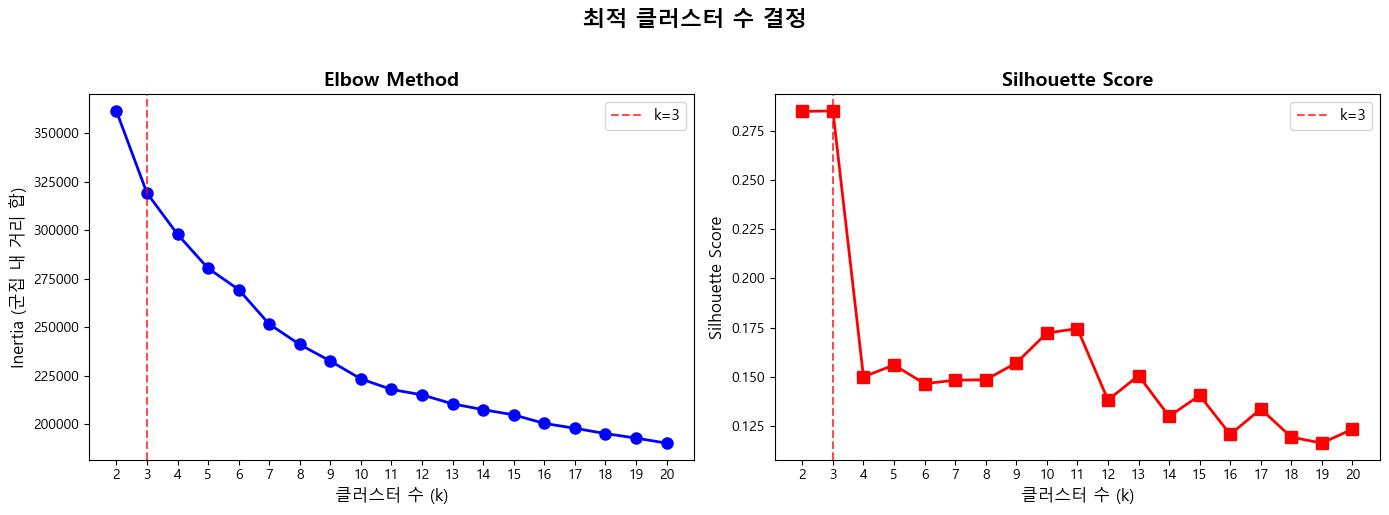

Silhouette Score 기준 최적 k = 3


In [7]:
# 최적의 클러스터 수 탐색 (Elbow + Silhouette)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K_range = range(2, 21)
# k를 2~20까지 바꿔가며 테스트 진행
inertias, silhouettes = [], []  #엘보우, 실루엣 

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10) # 가장 좋은 결과 = 가장 작은 inertia
    labels = km.fit_predict(X_processed)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_processed, labels,
                                        sample_size=5000, random_state=42))

best_k = list(K_range)[np.argmax(silhouettes)]



fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(list(K_range), inertias, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'k={best_k}')
axes[0].set_xlabel('클러스터 수 (k)', fontsize=12)
axes[0].set_ylabel('Inertia (군집 내 거리 합)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].set_xticks(list(K_range))

axes[1].plot(list(K_range), silhouettes, 'rs-', linewidth=2, markersize=8)
axes[1].axvline(x=best_k, color='red', linestyle='--', alpha=0.7, label=f'k={best_k}')
axes[1].set_xlabel('클러스터 수 (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].set_xticks(list(K_range))

plt.suptitle('최적 클러스터 수 결정', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f'Silhouette Score 기준 최적 k = {best_k}')

In [8]:
 # K-Means 클러스터링 수행
 # 최적이 K = 3 이라고 해서 

best_k = 5
 
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_processed)

X_train_copy = X_train.copy()
X_train_copy['cluster'] = clusters
X_train_copy['y'] = y_train.values

print(f'{len(X_train_copy):,}명의 고객을 5개 그룹으로 분류 완료')
X_train_copy['cluster'].value_counts().sort_index()

32,950명의 고객을 5개 그룹으로 분류 완료


cluster
0     1238
1    11506
2    10589
3     2127
4     7490
Name: count, dtype: int64

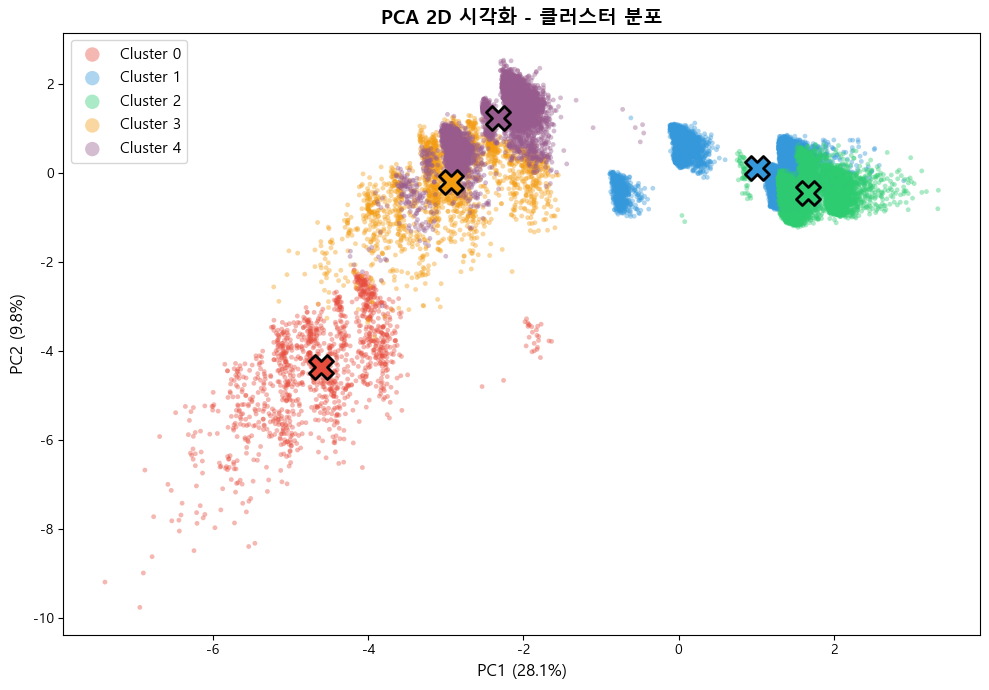

In [9]:
# PCA 시각화 - 클러스터 분포 확인

from sklearn.decomposition import PCA

pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(
    X_processed.toarray() if hasattr(X_processed, 'toarray') else X_processed
)

colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', "#985b8d" ]
labels_name = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

centroids_pca = pca.transform(kmeans.cluster_centers_)

fig, ax = plt.subplots(figsize=(10, 7))
for i in range(5):
    mask = clusters == i
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=colors[i], label=labels_name[i], alpha=0.4, s=12, edgecolors='none')
    
# centroid 표시
for i in range(5):
    plt.scatter(centroids_pca[i, 0], centroids_pca[i, 1],
                c=colors[i], marker='X', s=300, edgecolors='black',
                linewidths=2, zorder=5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax.set_title('PCA 2D 시각화 - 클러스터 분포', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, markerscale=3)
plt.tight_layout()
plt.show()

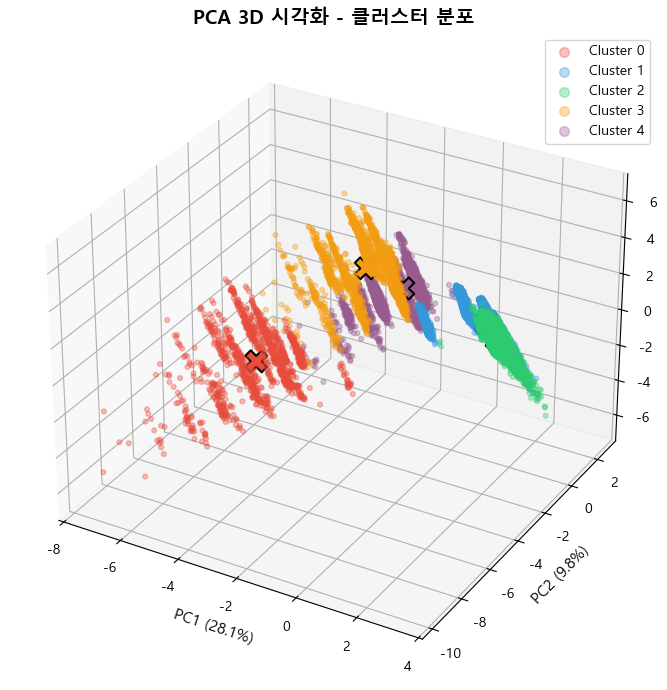

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1) PCA 3차원
X_dense = X_processed.toarray() if hasattr(X_processed, "toarray") else X_processed

pca = PCA(n_components=3, svd_solver="randomized", random_state=42)
X_pca = pca.fit_transform(X_dense)

# 2) 색/라벨
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', "#985b8d"]
labels_name = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4']

# 3) centroid를 PCA 공간으로
centroids_pca = pca.transform(kmeans.cluster_centers_)

# 4) 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i in range(5):
    mask = (clusters == i)
    ax.scatter(
        X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
        c=colors[i], label=labels_name[i], alpha=0.35, s=12
    )

# centroid 표시 (3D 축에)
ax.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1], centroids_pca[:, 2],
    c=colors, marker='X', s=250, edgecolors='black', linewidths=1.5, depthshade=False
)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})', fontsize=11)
ax.set_title('PCA 3D 시각화 - 클러스터 분포', fontsize=14, fontweight='bold')

ax.legend(fontsize=10, markerscale=2)
plt.tight_layout()
plt.show()


In [27]:
cluster_summary = X_train_copy.groupby('cluster').agg(
    고객수=('cluster', 'count'),
    평균나이=('age', 'mean'),
    평균캠페인횟수=('campaign', 'mean'),
    평균pdays=('pdays', 'mean'),
    이전접촉횟수=('previous', 'mean'),
    유리보금리=('euribor3m', 'mean'),
    고용자수=('nr.employed', 'mean'),
    가입률=('y', 'mean')
).round(2)

cluster_summary['가입률'] = (cluster_summary['가입률'] * 100).round(1).astype(str) + '%'
cluster_summary

,고객수,평균나이,평균캠페인횟수,평균pdays,이전접촉횟수,유리보금리,고용자수,가입률
cluster,,,,,,,,
0,1238,41.72,1.81,15.62,1.70,0.98,5027.75,63.0%
1,11506,40.18,2.70,999.00,0.05,4.75,5220.07,6.0%
2,10589,40.22,2.88,999.00,0.00,4.89,5206.30,4.0%
3,2127,45.39,1.86,999.00,0.40,0.82,5029.67,36.0%
4,7490,37.65,2.21,999.00,0.30,1.31,5091.50,14.0%


비지도 학습 K-Means 클러스터링 분석 결과 

범주형 (10) | job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome 

수치형 (9) | age, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed 


**Cluster 0 - 이전 성공 이력 + 우량 고객 (1,238명, 3.8%) -> 가입률 62.9% 

- 이전 캠페인 성공 이력 보유 · 최근 접촉 이력 · 저금리 환경
- 소수지만 가입률 63%로 ROI 극대화 가능 ** 최우선 타겟 **

**Cluster 3 - 저금리 시기 · 재접촉 고객 (9,608명, 29.2) -> 가입률 19.2% 

- 저금리 시기 접촉 · 이전 캠페인 실패 이력 · 재접근 가치 있음 
- 이전 실패했지만 경제 여건이 우호적이므로 재시도 권장 ** 2순위 타겟 ** 

**Cluster 4 - 일반금리 시기 · 신규 고객 (7,490명, 22.7%) -> 가입률 14.0%

- 일반 금리 · 이전 접촉 이력 존재 · 평균적인 캠페인 반응 구조
- 대량 고객 기반 확보용 그룹  ** 비용 효율적 선발 접근 필요 **

**Cluster 1 - 고금리 시기 · 신규 고객 (11,506명, 34.9%)  -> 가입률 6.0%

- 고금리 · 이전 접촉 거의 없음 · 신규 고객
- 즉시 마케팅 효율이 낮음 -> 저비용 중심 관리 필요

**Cluster 2 - 고금리 · 신규 고객 · 접촉 X (10,589명, 32.1%) -> 가입률 4.0%

- 가장 높은 금리 · 이전 접촉 없음 · 신규 고객 · 관심 X 
- 마케팅 비용 대비 효과 최저 -> 예산 투입 비권장 ** 최하위 그룹 **

최우선 / 고가치 확장 / 보조 타켓 / 저효율
 C0   ->    C3     ->    C4   ->   C1, 2
 